In [38]:
import MDAnalysis as mda
import numpy as np
import sys
import matplotlib.pyplot as plt
nav = mda.units.N_Avogadro

from datetime import date
today = date.today()

import time
import gc
gc.collect()


0

In [39]:
print(today)

2021-11-29


In [40]:
class FormFactor(object):
    """
    Calculates form factors from density profiles.
    
    Further development will include thickness of the membrane 
    from the intersection of lipid density and water density.
    Already enables to calculate electrom/mass/number densities
    
    Density could be calculated only from the final form factor profile 
    - testing is needed to see stability for rare species.
    
    Examination of FF error spikes is needed!
    
    """
    def __init__(self, conf,traj,nbin,bsize,output,center,group,density_type="electron"):
        path = "/home/ricky/Downloads/"
        self.conf = conf
        self.traj = traj
        start_time=time.time()
        self.uni = mda.Universe(self.conf,self.traj)
        print("Loading the trajectory takes {:10.6f} s".format(time.time()-start_time))
        
        #group to calculate  mass or number densities - should be extended to more than 1 group!
        self.u = self.uni.select_atoms(group)
        self.group=group
        
        #number of bins
        self.nbin = nbin
        #the totatl box size in [nm] - will be probably removed and tpr box size or 
        #transform of final FF will be used instead
        self.bsize = bsize
        self.output = output
        self.center = center
        
        self.density_type = density_type
        
        self.calculate_weight()
        

        self.calculate_density()
        
    def calculate_weight(self):
        """
        Creates an array of weights for all atoms in the simulation.
        
        For electron densities:
         - creates dictonary of atom types and number of electrons
           loaded form an external file --> in the future it backmaps 
                                            the atom names to mapping files
                                            and automaticaly assigns # of electrons
                                            
        Number densities:
         - all weights are 1
         
        Mass densities:
         - reads masses from u.atoms.masses
        """
        start_time=time.time()
        if self.density_type=="electron":
            with open ('electrons.dat') as f:
                rawdata = f.read().split('\n')
                lines= rawdata[0:len(rawdata)-1]
                tmp_atoms = np.asarray([l.split()[0:2] for l in lines])
                electrons = dict([ (elem[0],int(elem[1])) for elem in tmp_atoms])
        
            #weights to calculate the electron density
            wght=np.zeros(self.u.atoms.names.shape[0])
            for i in range (0,self.u.atoms.names.shape[0]):
                wght[i]=electrons[self.u.atoms.names[i]]
            self.wght=wght
        if self.density_type=="number":
            self.wght=np.ones(self.u.atoms.names.shape[0])
        if self.density_type=="mass":
            self.wght=self.u.atoms.masses
            
        print("Creating the electron mapping dictonary takes {:10.6f} s".format(time.time()-start_time))

    def calculate_density(self):

        
        c = self.uni.select_atoms(self.center)

        
        
        box_z = self.u.dimensions[2]
        d =  2*box_z/ self.nbin/10 #     # bin width
        boxH = box_z/10
        x = np.linspace(-boxH,boxH,self.nbin+1)[:-1] + d/2
        fx = np.zeros(self.nbin)
        fa=[]
        fb=[]

        """Calculte density profiles and FF from individual frames"""
        start_time=time.time()
        min_z=10000000
        beginning_time=self.uni.trajectory.time
        for ts in self.uni.trajectory:
            #count the index of the frame, numbered from 0, used to be used for the density profile averaging
            #posible not needed now
            frame = ts.frame
            end_time = ts.time
            #print(frame)
            

            
            #reads the dimension in z-direction
            box_z = ts.dimensions[2]
            if box_z/10<min_z:
                min_z=box_z/10
            
            #print(min_z)

            
            #reads the coordinates of all of the atoms
            crds = self.u.atoms.positions
            
            #calculates the center of mass of the selected atoms that the density should be centered around and 
            #takes the z-coordinate value
            ctom = c.atoms.center_of_mass()[2]
            
            #moves the center of mass of the selected centering group into box/2
            crds[:,2] += box_z/2 - ctom
            
            """shifts the coordinates in the universe by the value of the center of mass"""
            self.u.atoms.positions = crds
            
            """puts the atoms back to the original box dimension; it possibly does not take PBC into account
            #therefore it may brake some of the water molecules; try it, come to the issue later"""
            self.u.atoms.pack_into_box()
            
            """shif the coordinates so that the center in z-dimention is in 0; 
            #divide by 10 to get the coordinates in nm, since now the crds are only the z coordinates"""
            crds = (self.u.atoms.positions[:,2] - box_z/2)/10
            
            #gets the box-z size in nm
            box_z /= 10
            
            """calculates the volume of the bin; d- the "height" of a bin; assumes in [nm] """
            # ts.dimension[0], ts.dimension[1] - the x and y dimension; in [A] --> devides by 100
            vbin = d*np.prod(ts.dimensions[:2])/100
            
            #start_time2=time.time()

            d_ff =  box_z/ self.nbin
            vbin_FF =d_ff*np.prod(ts.dimensions[:2])/100    
            ff_density=np.histogram(crds,bins=self.nbin,range=(-box_z/2,box_z/2),weights=self.wght/vbin_FF)[0]
            FF_range = np.linspace(0,999,1000)  
            
            
            

            """calculates the total density profile; keep for now"""
            fx += np.histogram(crds,bins=self.nbin,range=(-boxH,boxH),weights=self.wght/vbin)[0]
            #fx += np.histogram(crds,bins=self.nbin,range=(-boxH,boxH),weights=self.u.atoms.masses/vbin)[0]
        print("Calculating the density takes {:10.6f} s".format(time.time()-start_time))


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """ Normalizing the profiles """
        fx /= (frame+1) 
        
        

        """ Symmetrizing profile if necessary """
        #if args.symmetrize :
        #    fx += fx[::-1]
        #    fx /=2


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """ Post-processign data and writing to file """
        density_data = np.vstack((x,fx)).transpose()
        
        
        """Post-processing of FF data from individual runs"""
        
        
    
        
        
       
        """Get the indexes of the final density data where all the time steps contribute
        In other words, take the coordinates of the smalest box from the simulation"""
        final_FF_start=int(np.round(self.nbin/2-min_z/d/2))+1
        final_FF_end=int(np.round(self.nbin/2+min_z/d/2))-1
        
  
        
        fa_aver, fb_aver = self.fourier(density_data[final_FF_start:final_FF_end,1],density_data[final_FF_end,0]-density_data[final_FF_start,0],FF_range,density_data[1,0]-density_data[0,0])
        
        """Plot density profiles from the average density with minimal box"""
        self.plot_density(density_data[final_FF_start:final_FF_end,:])
        self.plot_density(density_data)
        
        
        with open(str(self.output)+".finalDensity", 'w') as f:
            f.write("# Density profile calculated from '{}'\n".format(self.traj))
            f.write("# Density profile of '{}'\n".format(self.group))
            f.write("# Density centered around '{}'\n\n".format(self.center))
            
            f.write("# Beginning time: {} ns \n# End time: {} ns \n".format(beginning_time/1000,end_time/1000))
            f.write("# Time Step: {} ns \n\n".format(self.uni.trajectory[2].time/1000-self.uni.trajectory[1].time/1000))
            
            f.write("# Analyzed by R Nencini, ricky.nencini@helsinki.fi / nencini.ricky@gmail.com \n")
            f.write("# Analyzed on '{}'\n\n".format(today))

            
            np.savetxt(f, density_data[final_FF_start+1:final_FF_end-1,:],fmt='%8.4f  %.8f')
        
        """Save data into files"""
        
        
        
    def plot_density(self,data):
        #data=np.loadtxt(self.output)
        plt.figure(figsize=(15, 6))
        plt.plot(data[:,0],data[:,1])
        plt.xlabel("Membrane normal [nm]")
        plt.show()
        

    
    def plot_fourier_final(self,data):
        plt.figure(figsize=(15, 6))
        plt.plot(data[:,0],data[:,1])
        plt.xlabel("q [A]")
        plt.show()
        
    def plot_fourier_final_run(self,data,data2):
        plt.figure(figsize=(15, 6))
        plt.plot(data[:,0],data[:,1])
        plt.errorbar(data[:,0],data[:,1],data[:,2])
        plt.plot(data2[:,0],data2[:,1])
        plt.xlabel("q [A]")
        plt.show()
        
    
    def fourier(self,ff_density,box_z,FF_range,d_ff):
        """Calculates fourier transform of ff_density in the FF_range"""
        #calculate a "height" of a bin for FF puroposes; in this case the number of bins is constant and the 
        #bin width changes
        
        
        """Creates the direct space coordinates"""
        #the calculations are stable with rounding (and others) errors in the direct space coordinates
        ff_x = np.linspace(-box_z/2,box_z/2,ff_density.shape[0]+1)[:-1] + box_z/(2*ff_density.shape[0])
        ff_x2 = np.linspace(-box_z/2,box_z/2,ff_density.shape[0]+1)[:-1] + d_ff/2
             
        
        k=0
        bulk=0
        while k*d_ff<0.33:
            bulk+=ff_density[k]+ff_density[-k-1]
            #print("The densities from the left and right ends are: {} {}".format(ff_density[k],ff_density[-k-1]))
            k+=1
        bulk/=(2*k)
        #print("The bulk density is {}".format(bulk))

            
        fa=np.zeros(FF_range.shape[0])
        fb=np.zeros(FF_range.shape[0])

        
        for j in range (0,ff_density.shape[0]):
            fa+=(ff_density[j]-bulk)*np.cos(FF_range*ff_x[j]*0.01)*d_ff
            fb+=(ff_density[j]-bulk)*np.sin(FF_range*ff_x[j]*0.01)*d_ff
            
 

        return fa, fb
 
               



In [49]:
FormFactor('etidocaine_POPC_CHARMM_298K_Cl_countra_140mM_20000waters.tpr',"etidocaine_POPC_CHARMM_298K_Cl_countra_140mM_20000waters_skip10_b2700_e4700.xtc",200,5,'ETI_swiss_140',"resname POPC","resname ETI","number")

FileNotFoundError: [Errno 2] No such file or directory: 'etidocaine_POPC_CHARMM_298K_Cl_countra_140mM_20000waters.gro'

Loading the trajectory takes   5.469168 s
Creating the electron mapping dictonary takes   0.000103 s
Calculating the density takes  19.392164 s


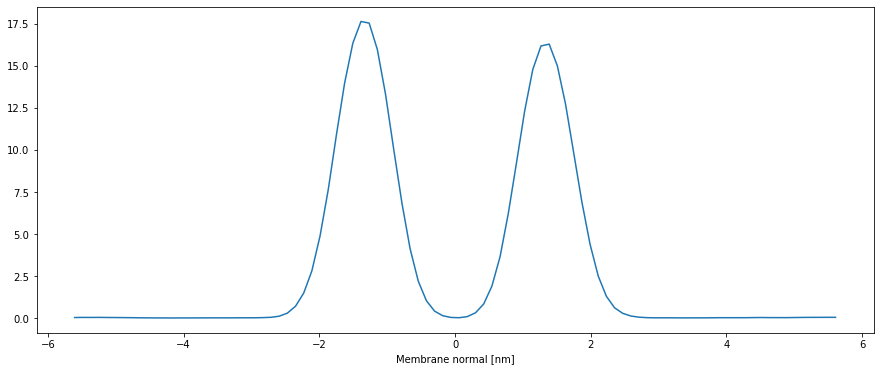

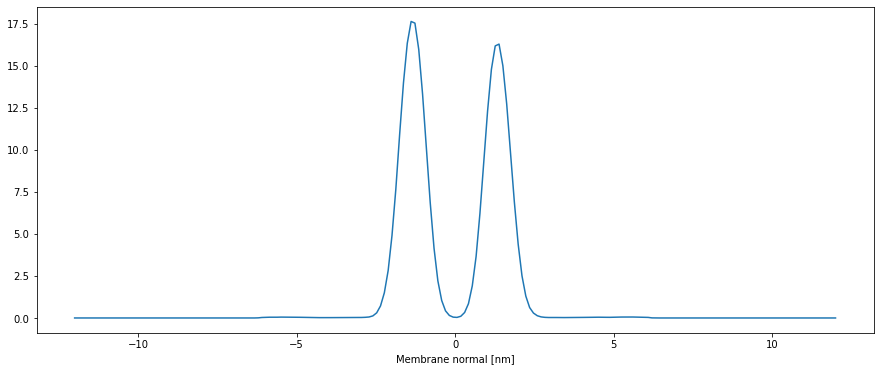

In [43]:
FormFactor('etidocaine_POPC_CHARMM_298K_Cl_countra_140mM_19900waters_paramchem_ECC_skip4_b600.gro',"etidocaine_POPC_CHARMM_298K_Cl_countra_140mM_19900waters_paramchem_ECC_skip4_b600.xtc",200,5,'ETI_paramchem_ECC_140',"resname POPC","resname ETI","number")

Loading the trajectory takes   1.530731 s
Creating the electron mapping dictonary takes   0.000095 s
Calculating the density takes  11.626959 s


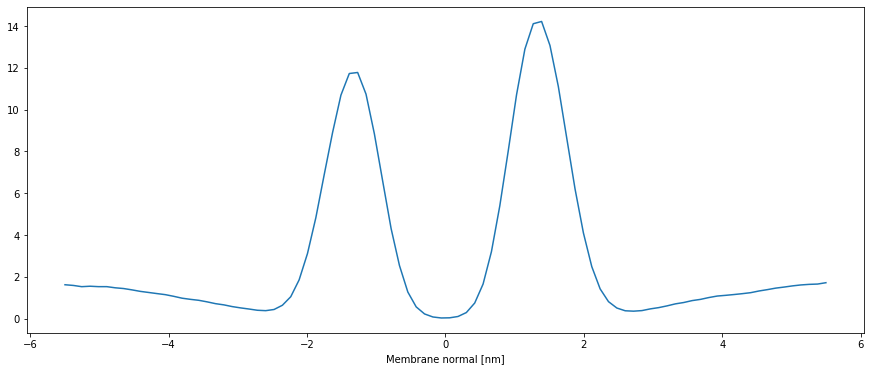

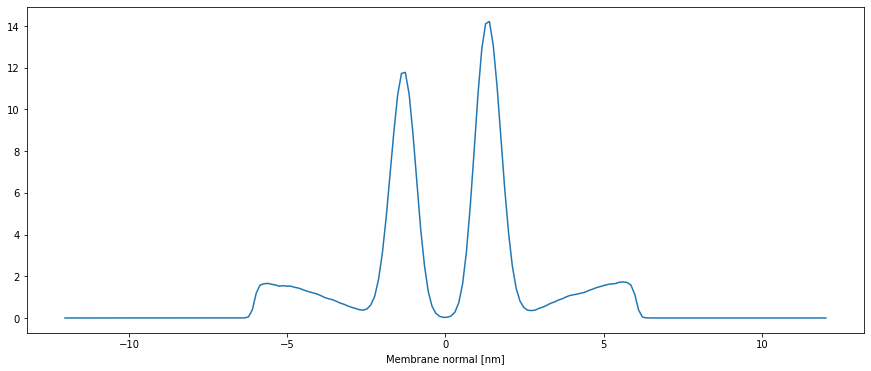

In [44]:
FormFactor('etidocaine_POPC_CHARMM_298K_Cl_countra_140mM_20000waters_paramchem_skip10_b2000.gro',"etidocaine_POPC_CHARMM_298K_Cl_countra_140mM_20000waters_paramchem_skip10_b2000.xtc",200,5,'ETI_paramchem_140',"resname POPC","resname ETI","number")

Loading the trajectory takes   2.037787 s
Creating the electron mapping dictonary takes   0.000075 s
Calculating the density takes  24.265307 s


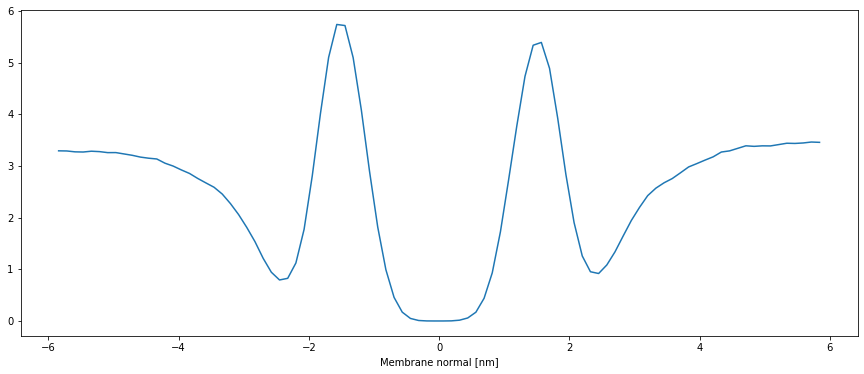

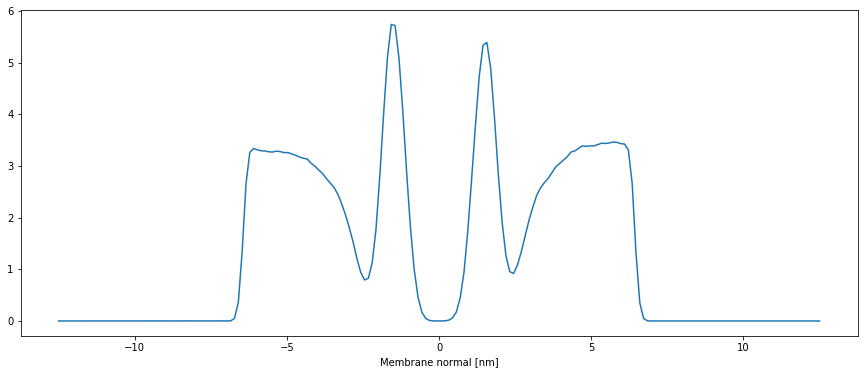

In [47]:
FormFactor('TPP_POPC_CHARMM36_298K_140mM_20000waters.tpr',"TPP_POPC_CHARMM36_298K_140mM_20000waters_skip5_b1000.xtc",200,5,'TPP_proteinFF_140',"resname POPC","resname TPA","number")

Loading the trajectory takes   0.708682 s
Creating the electron mapping dictonary takes   0.000131 s
Calculating the density takes  17.938917 s


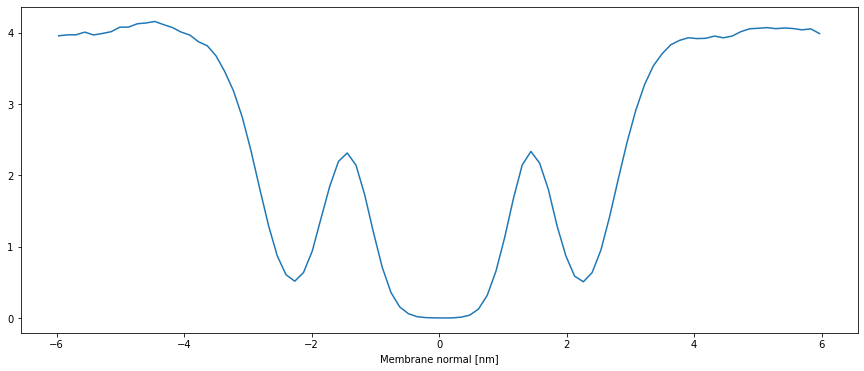

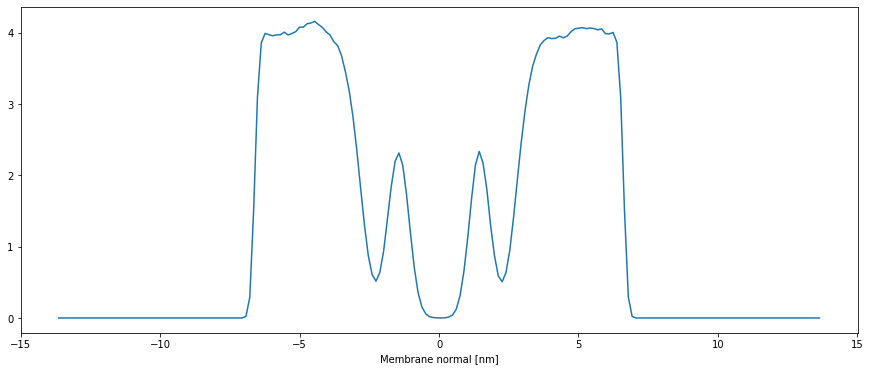

In [51]:
FormFactor('TPP_POPC_CHARMM36_298K_140mM_20000waters_paramchem_B3LYP_ESP_charges.gro',"TPP_POPC_CHARMM36_298K_140mM_20000waters_paramchem_B3LYP_ESP_charges_skip5_b1000.xtc",200,5,'TPP_B3LYP_140',"resname POPC","resname TPP","number")

Loading the trajectory takes   1.919961 s
Creating the electron mapping dictonary takes   0.000104 s
Calculating the density takes  18.647084 s


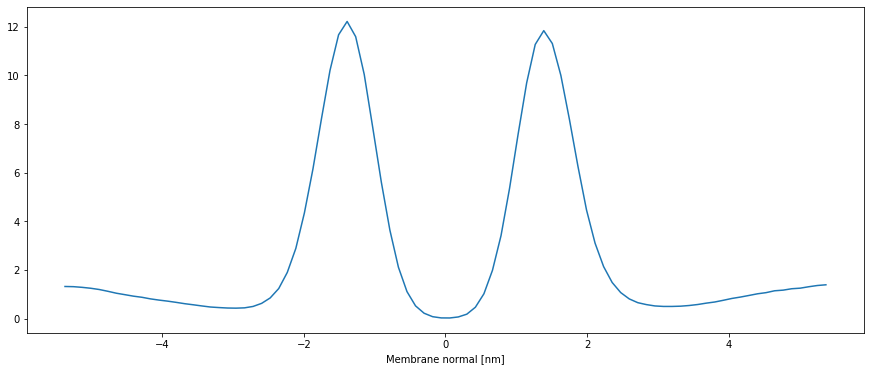

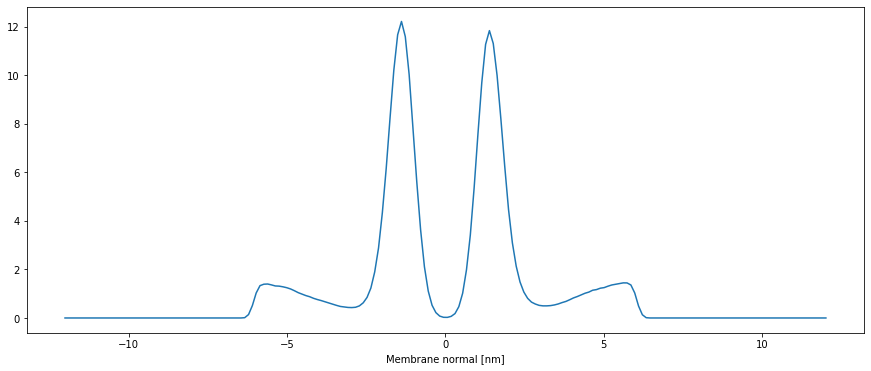

In [52]:
FormFactor('TPP_POPC_CHARMM36_298K_140mM_20000waters_paramchem_B3LYP_ESP_charges_ECC.gro',"TPP_POPC_CHARMM36_298K_140mM_20000waters_paramchem_B3LYP_ESP_charges_ECC_skip5_b1000.xtc",200,5,'TPP_B3LYP_ECC_140',"resname POPC","resname TPP","number")

In [53]:
pwd

'/home/ricky/Documents/from_work/papers/electro/11-marr/density_for_fig_2'